In [2]:
import jax.numpy as jnp
import jax
from fbpinns.problems import Problem

class Schrodinger1D(Problem):
    """
    Solves the 1D time-dependent Schrödinger equation for the harmonic oscillator:

         i ψ_t = -½ ψ_{xx} + ½ ω² x² ψ,

    where the complex wavefunction ψ is split into real and imaginary parts:
         ψ(x,t) = u(x,t) + i v(x,t).

    This leads to a coupled system of two real PDEs:
    
         - v_t + ½ u_{xx} - ½ ω² x² u = 0,   (Equation 1)
         u_t + ½ v_{xx} - ½ ω² x² v = 0.      (Equation 2)
    
    The initial condition is chosen to be the ground state of the harmonic oscillator:
    
         ψ(x,0) = ψ₀(x) = (ω/π)^(¼) exp(-ω x²/2),
    
    so that u(x,0) = ψ₀(x) and v(x,0) = 0.
    
    The spatial domain is chosen as x ∈ [-L, L] (with L sufficiently large so that ψ ≈ 0 at x = ±L)
    and time t ∈ [0, T].
    """

    @staticmethod
    def init_params(omega=1.0, L=5.0, sd=0.1):
        # Define the dimensionality:
        #   ud = 2 (two outputs: u and v)
        #   xd = 2 (two inputs: x and t)
        static_params = {
            "dims": (2, 2),
            "omega": omega,
            "L": L,
            "sd": sd
        }
        return static_params, {}

    @staticmethod
    def sample_constraints(all_params, domain, key, sampler, batch_shapes):
        # Sample interior collocation points from the domain
        x_batch = domain.sample_interior(all_params, key, sampler, batch_shapes[0])
        
        # For the two equations, we need the following derivatives:
        # For Equation (1): we require u, u_{xx} and v_t.
        # For Equation (2): we require v, v_{xx} and u_t.
        required_diffs = (
            (0, ()),     # u
            (0, (0, 0)), # u_xx
            (1, (1,)),   # v_t
            (1, ()),     # v
            (1, (0, 0)), # v_xx
            (0, (1,)),   # u_t
        )
        
        # Return two constraint groups, one for each equation.
        return [[x_batch, required_diffs],]

    @staticmethod
    def constraining_fn(all_params, x_batch, net_out):
        """
        Enforces both the initial condition and the boundary conditions by reparameterizing
        the network output.
        
        Let the raw network output be:
             N(x,t) = [N_u(x,t), N_v(x,t)].
        
        We define the full solution as:
        
            u(x,t) = A(x) * t * N_u(x,t) + ψ₀(x),
            v(x,t) = A(x) * t * N_v(x,t),
        
        where:
          - A(x) = (L² - x²)/L² is a spatial multiplier that vanishes at the boundaries x = ±L,
          - ψ₀(x) = (ω/π)^(¼) exp(-ω x²/2) is the initial wavefunction.
        
        In this way, at t = 0 the network’s contribution vanishes, ensuring that
        u(x,0) = ψ₀(x) and v(x,0) = 0, and the boundary conditions are automatically satisfied.
        """
        x = x_batch[:, 0:1]  # spatial coordinate
        t = x_batch[:, 1:2]  # time coordinate
        omega = all_params["static"]["problem"]["omega"]
        L = all_params["static"]["problem"]["L"]
        sd = all_params["static"]["problem"]["sd"]
        tanh = jax.nn.tanh
        
        # Spatial multiplier: A(x) goes to zero at x = ±L.
        # A = (L**2 - x**2) / (L**2)
        A = tanh((L+x)/sd) * tanh((L-x)/sd)
        
        # Define the initial condition (ground state of the harmonic oscillator)
        psi0 = (omega / jnp.pi)**0.25 * jnp.exp(-omega * x**2 / 2.0)
        
        # Split the raw network output into its two components.
        u = net_out[:, 0:1]
        v = net_out[:, 1:2]
        
        # Reparameterize to enforce the conditions.
        u = A * t * u + psi0
        v = A * t * v
        # Concatenate u and v to form the full two-component output.
        return jnp.concatenate([u, v], axis=1)

    @staticmethod
    def loss_fn(all_params, constraints):
        """
        Computes the physics residual for both equations:
        
        Equation (1): -v_t + ½ u_{xx} - ½ ω² x² u = 0.
        Equation (2):  u_t + ½ v_{xx} - ½ ω² x² v = 0.
        
        The loss is defined as the sum of the mean squared errors of the residuals for
        both equations.
        """
        omega = all_params["static"]["problem"]["omega"]
        
        # Group 1 corresponds to Equation (1).
        x_batch, u, uxx, vt, v, vxx, ut = constraints[0]

        # Extract the spatial coordinate for the potential term.
        x = x_batch[:, 0:1]
        # Residual for Equation (1)
        res1 = -vt + 0.5 * uxx - 0.5 * omega**2 * (x**2) * u
        
        # Residual for Equation (2)
        res2 = ut + 0.5 * vxx - 0.5 * omega**2 * (x**2) * v
        
        loss1 = jnp.mean(res1**2)
        loss2 = jnp.mean(res2**2)
        return loss1 + loss2

    @staticmethod
    def exact_solution(all_params, x_batch, batch_shape=None):
        """
        Returns the exact ground-state solution for the harmonic oscillator.
        
        The analytical solution (up to a global phase) is given by:
            u(x,t) = ψ₀(x) cos(ω t/2),
            v(x,t) = -ψ₀(x) sin(ω t/2),
        where ψ₀(x) = (ω/π)^(¼) exp(-ω x²/2).
        """
        omega = all_params["static"]["problem"]["omega"]
        x = x_batch[:, 0:1]
        t = x_batch[:, 1:2]
        psi0 = (omega / jnp.pi)**0.25 * jnp.exp(-omega * x**2 / 2.0)
        u = psi0 * jnp.cos(omega * t / 2.0)
        v = -psi0 * jnp.sin(omega * t / 2.0)
        return jnp.concatenate([u, v], axis=1)


[INFO] 2025-03-28 01:19:55 - <fbpinns.constants.Constants object at 0x7fb149609b50>
run: test
domain: <class 'fbpinns.domains.RectangularDomainND'>
domain_init_kwargs: {'xmin': array([-5.,  0.]), 'xmax': array([5.        , 1.57079633])}
problem: <class '__main__.Schrodinger1D'>
problem_init_kwargs: {}
decomposition: <class 'fbpinns.decompositions.RectangularDecompositionND'>
decomposition_init_kwargs: {'subdomain_xs': [array([-5.        , -4.47368421, -3.94736842, -3.42105263, -2.89473684,
       -2.36842105, -1.84210526, -1.31578947, -0.78947368, -0.26315789,
        0.26315789,  0.78947368,  1.31578947,  1.84210526,  2.36842105,
        2.89473684,  3.42105263,  3.94736842,  4.47368421,  5.        ]), array([0.        , 0.39269908, 0.78539816, 1.17809725, 1.57079633])], 'subdomain_ws': [array([1.52631579, 1.52631579, 1.52631579, 1.52631579, 1.52631579,
       1.52631579, 1.52631579, 1.52631579, 1.52631579, 1.52631579,
       1.52631579, 1.52631579, 1.52631579, 1.52631579, 1.52631579,

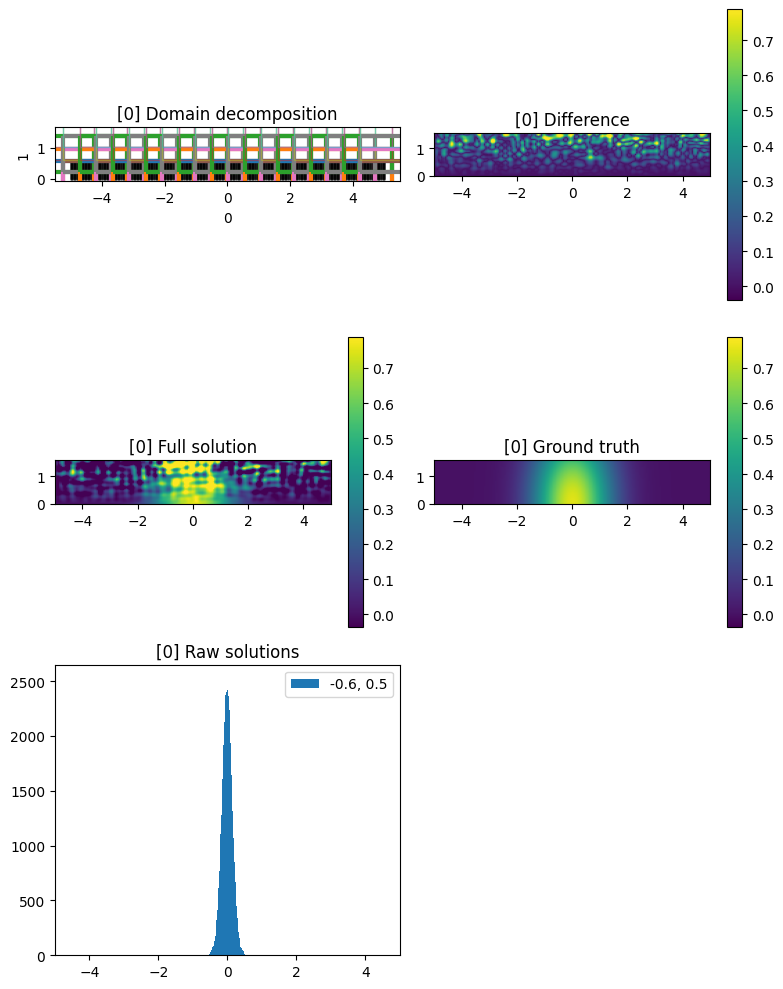

(2, 2) 2
True


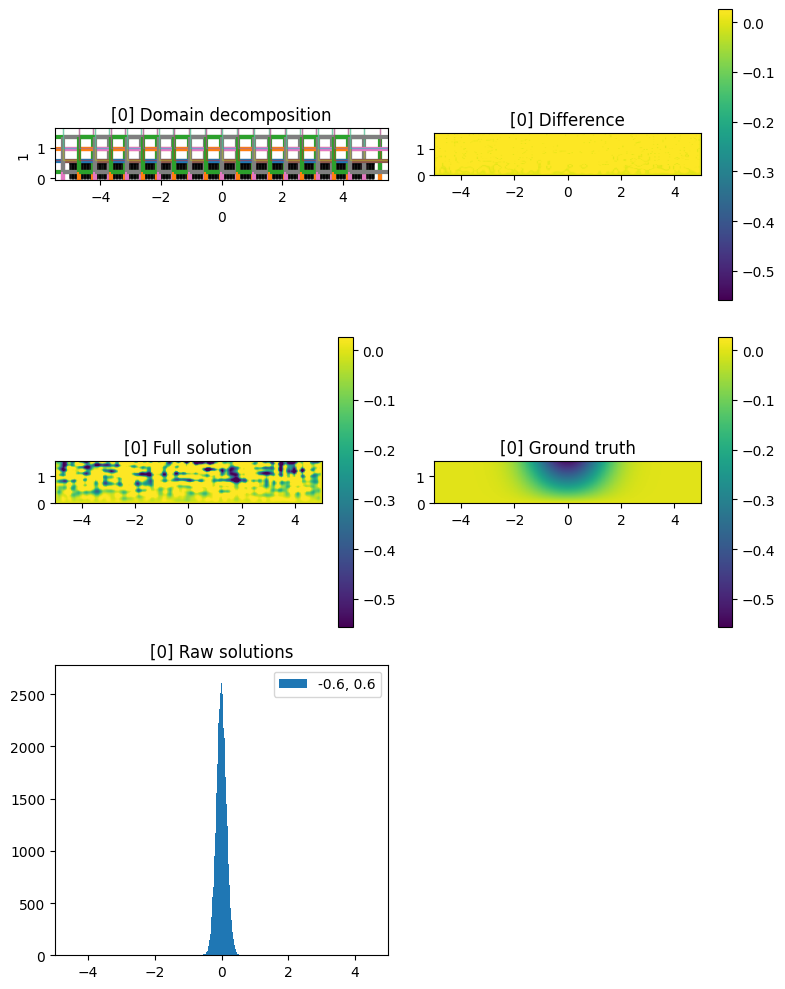

[INFO] 2025-03-28 01:20:05 - [i: 1000/50000] loss: 0.0058 rate: 197.5 elapsed: 0.00 hr test
[INFO] 2025-03-28 01:20:06 - [i: 2000/50000] loss: 0.0013 rate: 1026.9 elapsed: 0.00 hr test
[INFO] 2025-03-28 01:20:07 - [i: 3000/50000] loss: 0.0006 rate: 1028.6 elapsed: 0.00 hr test
[INFO] 2025-03-28 01:20:08 - [i: 4000/50000] loss: 0.0004 rate: 1024.6 elapsed: 0.00 hr test
[INFO] 2025-03-28 01:20:09 - [i: 5000/50000] loss: 0.0003 rate: 1030.4 elapsed: 0.00 hr test
(10000, 2) (10000, 2) (10000, 2) (76380, 2) (76380, 1) (76380, 2) (3600, 2) (200, 50)
(2, 2) 2
True


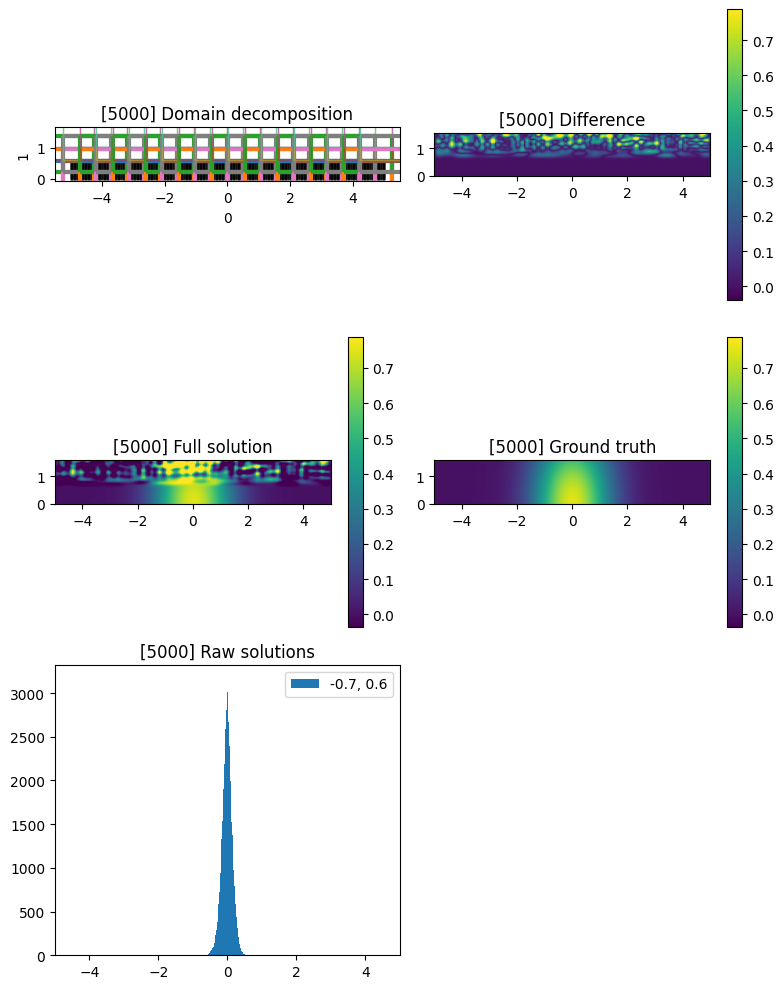

(2, 2) 2
True


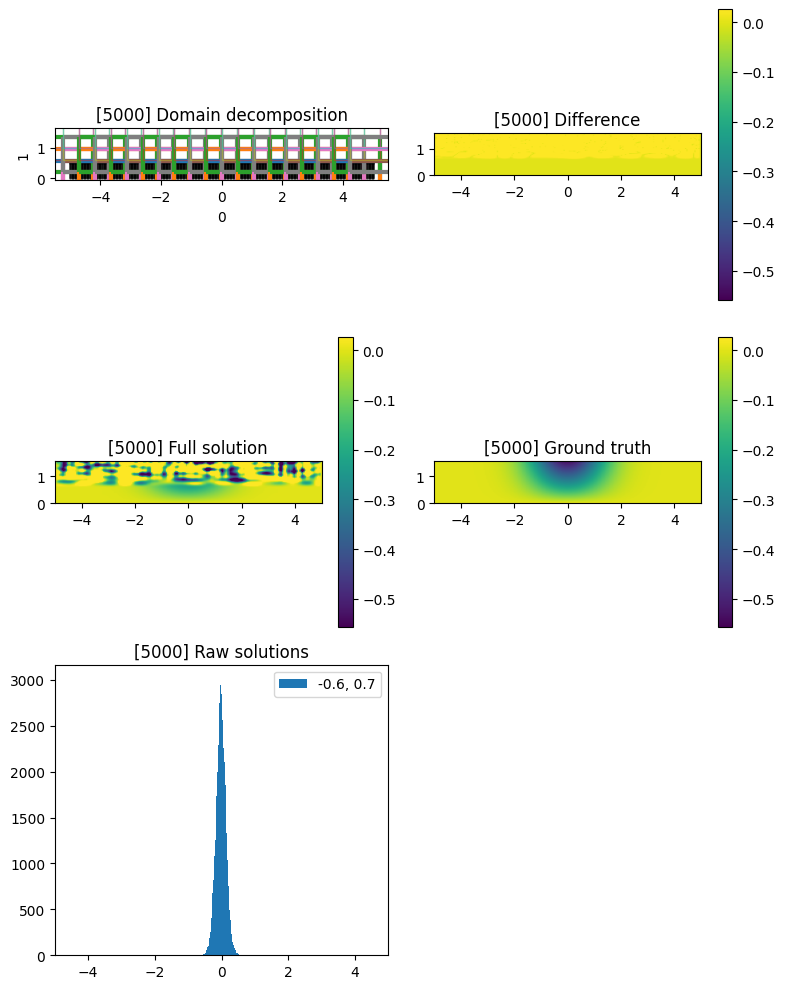

[INFO] 2025-03-28 01:20:10 - [i: 5556/50000] Updating active inputs..
[INFO] 2025-03-28 01:20:11 - [i: 5556/50000] Average number of points/dimension in active subdomains: 29.72
[INFO] 2025-03-28 01:20:12 - [i: 5556/50000] Updating active inputs done (1.59 s)
[INFO] 2025-03-28 01:20:12 - [i: 5556/50000] Compiling update step..
[INFO] 2025-03-28 01:20:12 - x_batch
[INFO] 2025-03-28 01:20:12 - (6200, 2), float32, JVPTracer
[INFO] 2025-03-28 01:20:12 - x_take
[INFO] 2025-03-28 01:20:12 - (48450, 2), float32, JVPTracer
[INFO] 2025-03-28 01:20:12 - x_batch
[INFO] 2025-03-28 01:20:12 - (6200, 2), float32, JVPTracer
[INFO] 2025-03-28 01:20:12 - x_take
[INFO] 2025-03-28 01:20:12 - (48450, 2), float32, JVPTracer
[INFO] 2025-03-28 01:20:14 - [i: 5556/50000] Compiling done (2.02 s)
[INFO] 2025-03-28 01:20:15 - [i: 6000/50000] loss: 0.0021 rate: 204.2 elapsed: 0.00 hr test
[INFO] 2025-03-28 01:20:17 - [i: 7000/50000] loss: 0.0011 rate: 582.5 elapsed: 0.01 hr test
[INFO] 2025-03-28 01:20:18 - [i: 8

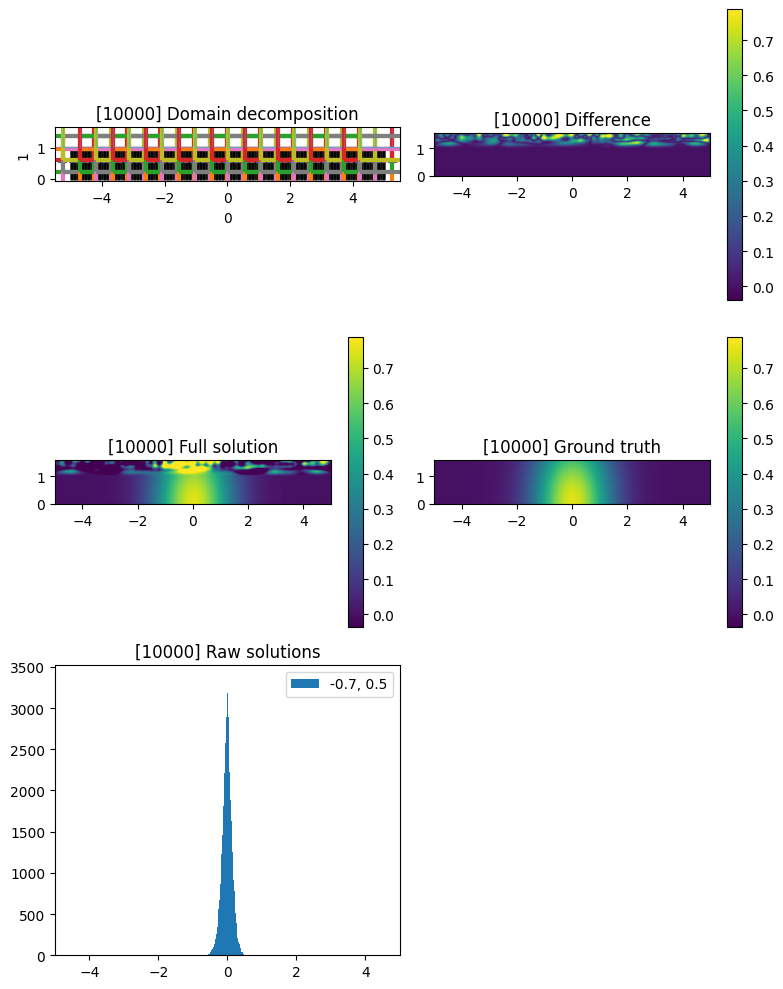

(2, 2) 2
True


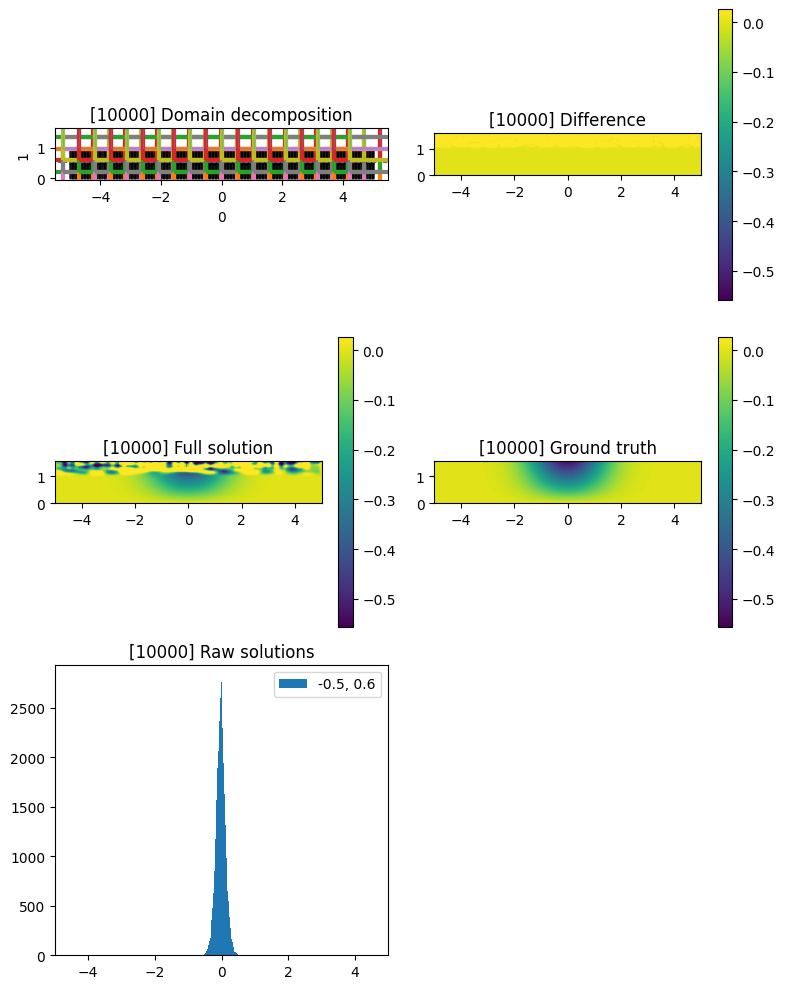

[INFO] 2025-03-28 01:20:25 - [i: 11000/50000] loss: 0.0012 rate: 580.3 elapsed: 0.01 hr test
[INFO] 2025-03-28 01:20:26 - [i: 12000/50000] loss: 0.0016 rate: 579.8 elapsed: 0.01 hr test
[INFO] 2025-03-28 01:20:28 - [i: 13000/50000] loss: 0.0015 rate: 579.3 elapsed: 0.01 hr test
[INFO] 2025-03-28 01:20:30 - [i: 14000/50000] loss: 0.0030 rate: 579.6 elapsed: 0.01 hr test
[INFO] 2025-03-28 01:20:32 - [i: 15000/50000] loss: 0.0014 rate: 579.3 elapsed: 0.01 hr test
(10000, 2) (10000, 2) (10000, 2) (76380, 2) (76380, 1) (76380, 2) (6200, 2) (200, 50)
(2, 2) 2
True


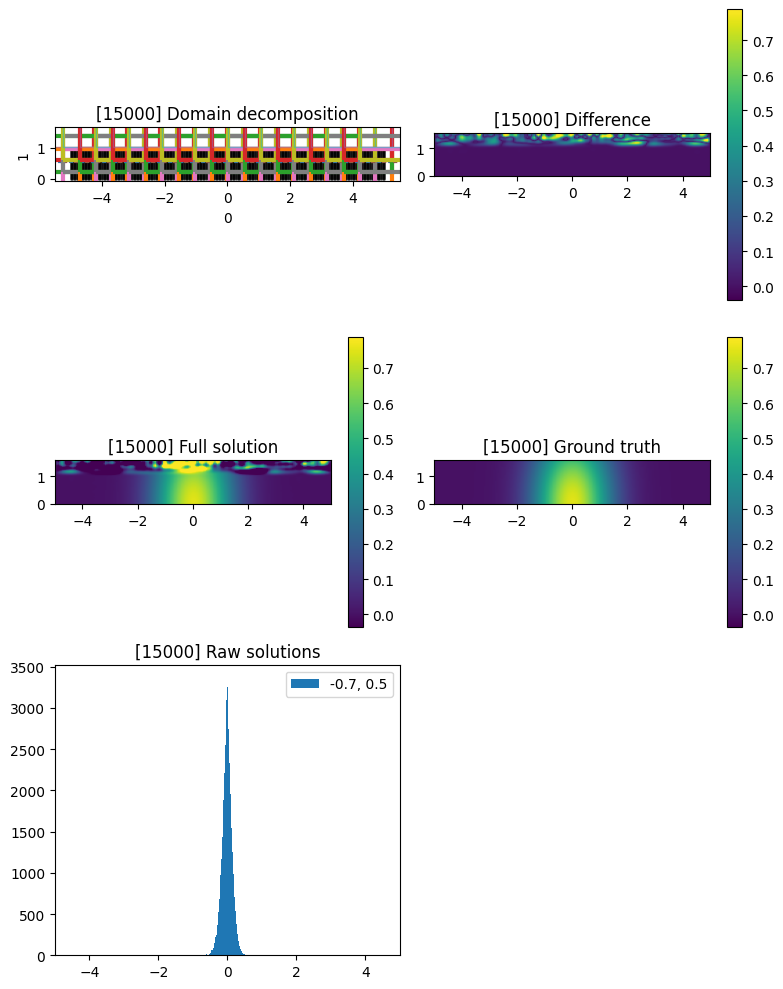

(2, 2) 2
True


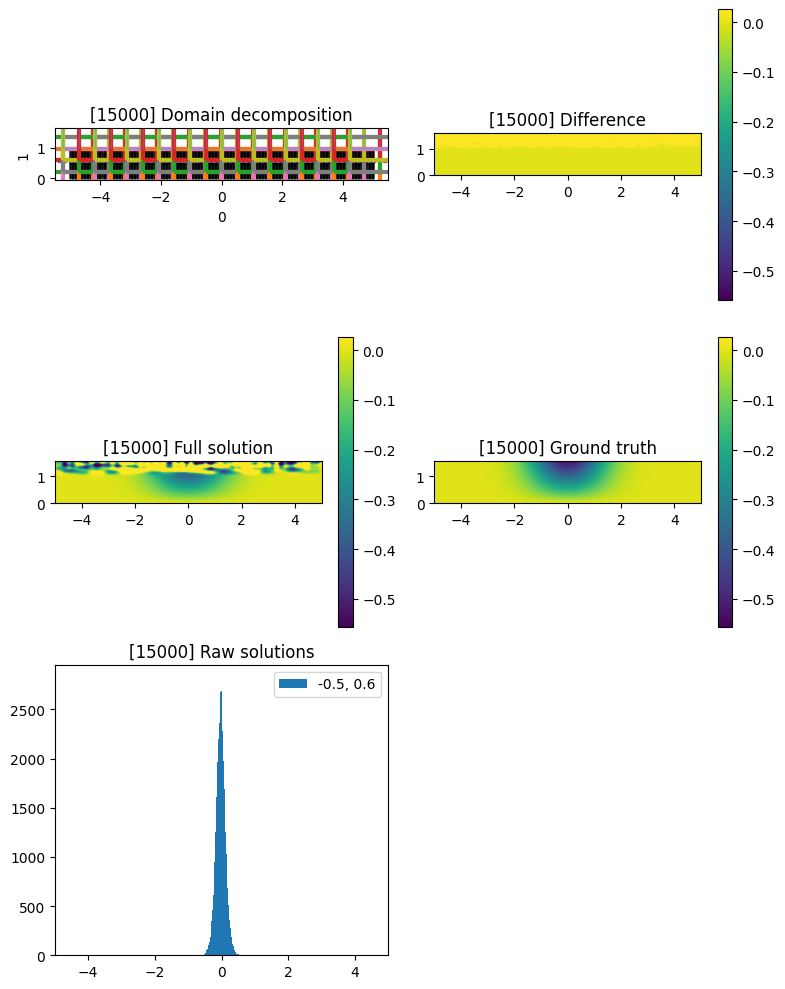

[INFO] 2025-03-28 01:20:34 - [i: 16000/50000] loss: 0.0014 rate: 580.3 elapsed: 0.01 hr test
[INFO] 2025-03-28 01:20:35 - [i: 16667/50000] Updating active inputs..
[INFO] 2025-03-28 01:20:36 - [i: 16667/50000] Average number of points/dimension in active subdomains: 32.03
[INFO] 2025-03-28 01:20:37 - [i: 16667/50000] Updating active inputs done (1.58 s)
[INFO] 2025-03-28 01:20:37 - [i: 16667/50000] Compiling update step..
[INFO] 2025-03-28 01:20:37 - x_batch
[INFO] 2025-03-28 01:20:37 - (7200, 2), float32, JVPTracer
[INFO] 2025-03-28 01:20:37 - x_take
[INFO] 2025-03-28 01:20:37 - (60420, 2), float32, JVPTracer
[INFO] 2025-03-28 01:20:37 - x_batch
[INFO] 2025-03-28 01:20:37 - (7200, 2), float32, JVPTracer
[INFO] 2025-03-28 01:20:37 - x_take
[INFO] 2025-03-28 01:20:37 - (60420, 2), float32, JVPTracer
[INFO] 2025-03-28 01:20:39 - [i: 16667/50000] Compiling done (2.24 s)
[INFO] 2025-03-28 01:20:40 - [i: 17000/50000] loss: 0.0025 rate: 176.6 elapsed: 0.01 hr test
[INFO] 2025-03-28 01:20:42 

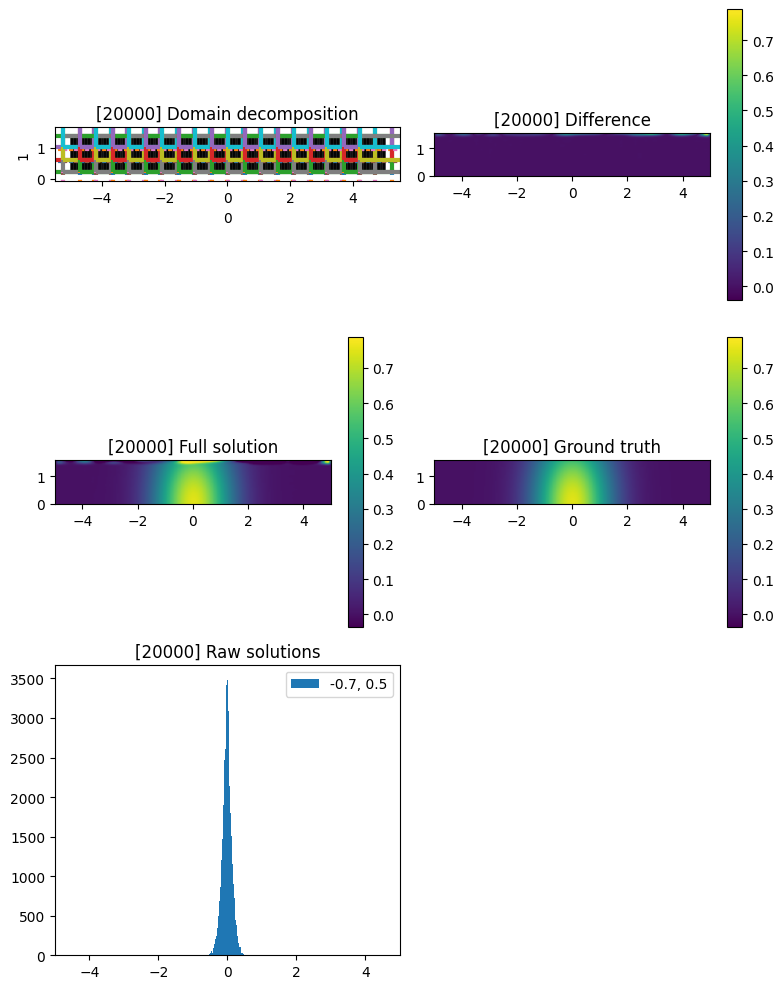

(2, 2) 2
True


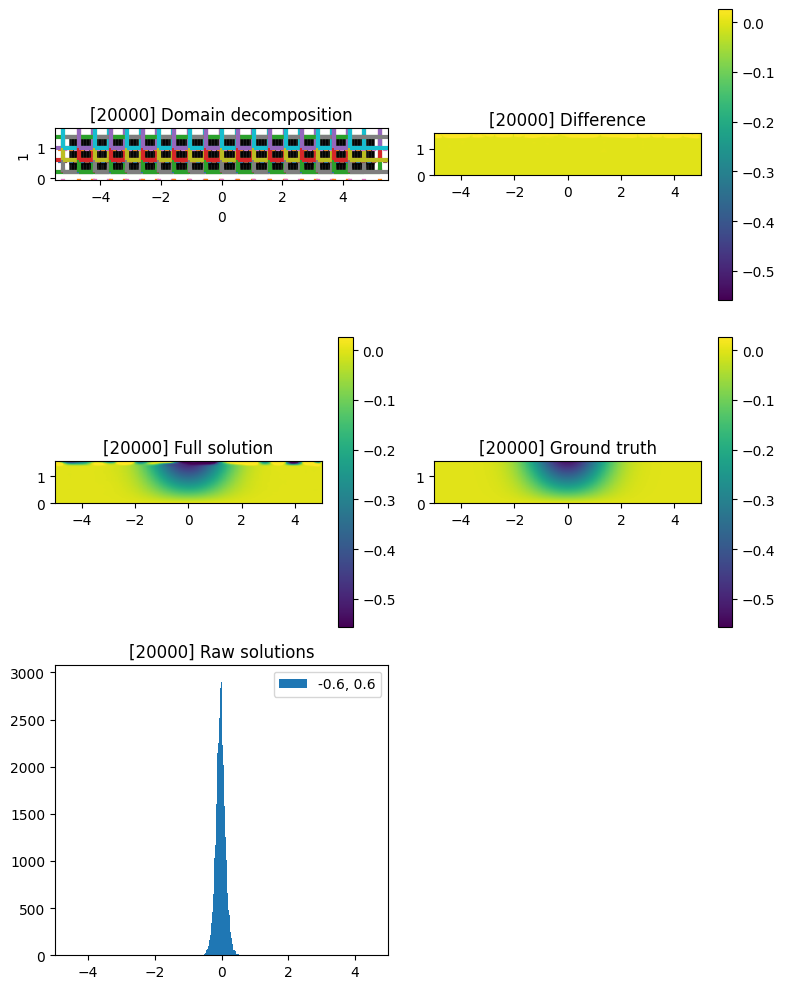

[INFO] 2025-03-28 01:20:50 - [i: 21000/50000] loss: 0.0029 rate: 466.8 elapsed: 0.01 hr test
[INFO] 2025-03-28 01:20:52 - [i: 22000/50000] loss: 0.0024 rate: 468.6 elapsed: 0.01 hr test
[INFO] 2025-03-28 01:20:54 - [i: 23000/50000] loss: 0.0034 rate: 467.9 elapsed: 0.02 hr test
[INFO] 2025-03-28 01:20:56 - [i: 24000/50000] loss: 0.0038 rate: 468.7 elapsed: 0.02 hr test
[INFO] 2025-03-28 01:20:58 - [i: 25000/50000] loss: 0.0025 rate: 468.0 elapsed: 0.02 hr test
(10000, 2) (10000, 2) (10000, 2) (76380, 2) (76380, 1) (76380, 2) (7200, 2) (200, 50)
(2, 2) 2
True


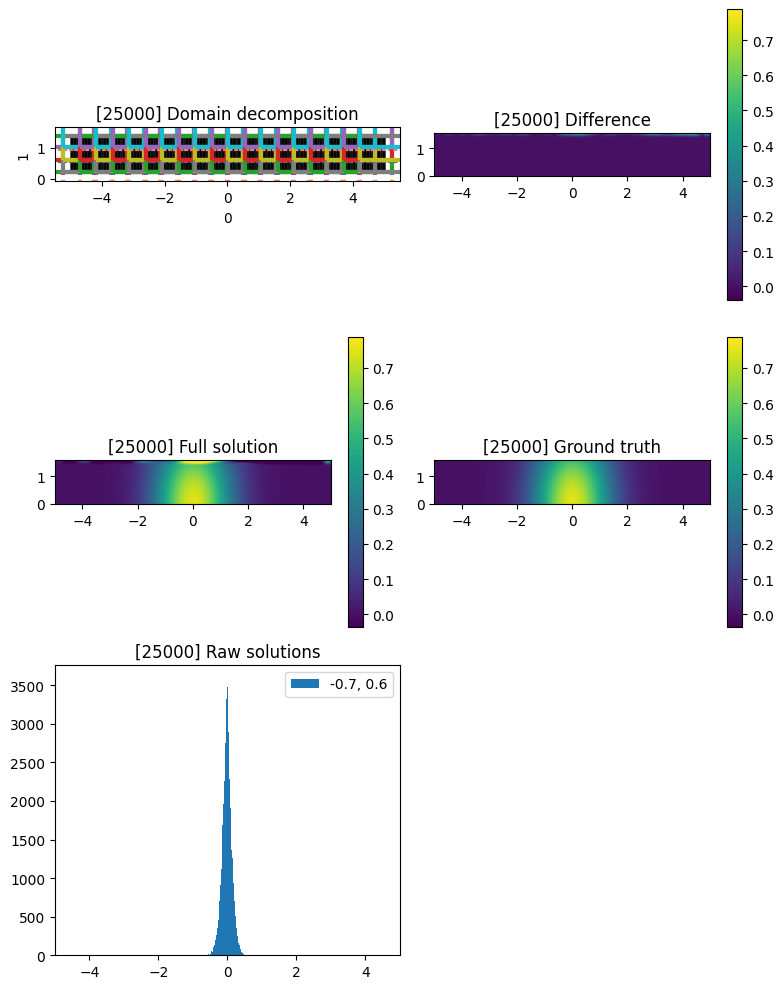

(2, 2) 2
True


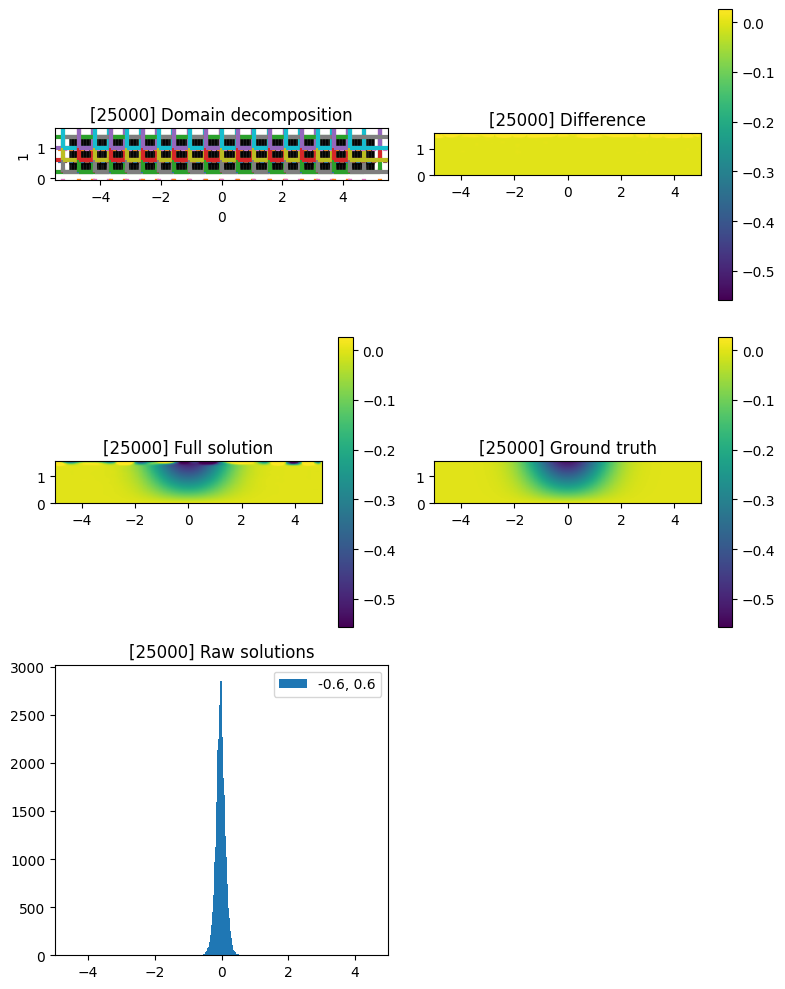

[INFO] 2025-03-28 01:21:01 - [i: 26000/50000] loss: 0.0047 rate: 468.0 elapsed: 0.02 hr test
[INFO] 2025-03-28 01:21:04 - [i: 27000/50000] loss: 0.0041 rate: 467.5 elapsed: 0.02 hr test
[INFO] 2025-03-28 01:21:05 - [i: 27778/50000] Updating active inputs..
[INFO] 2025-03-28 01:21:05 - [i: 27778/50000] Average number of points/dimension in active subdomains: 29.72
[INFO] 2025-03-28 01:21:06 - [i: 27778/50000] Updating active inputs done (0.12 s)
[INFO] 2025-03-28 01:21:06 - [i: 27778/50000] Compiling update step..
[INFO] 2025-03-28 01:21:06 - x_batch
[INFO] 2025-03-28 01:21:06 - (6200, 2), float32, JVPTracer
[INFO] 2025-03-28 01:21:06 - x_take
[INFO] 2025-03-28 01:21:06 - (48450, 2), float32, JVPTracer
[INFO] 2025-03-28 01:21:06 - x_batch
[INFO] 2025-03-28 01:21:06 - (6200, 2), float32, JVPTracer
[INFO] 2025-03-28 01:21:06 - x_take
[INFO] 2025-03-28 01:21:06 - (48450, 2), float32, JVPTracer
[INFO] 2025-03-28 01:21:07 - [i: 27778/50000] Compiling done (1.86 s)
[INFO] 2025-03-28 01:21:08 

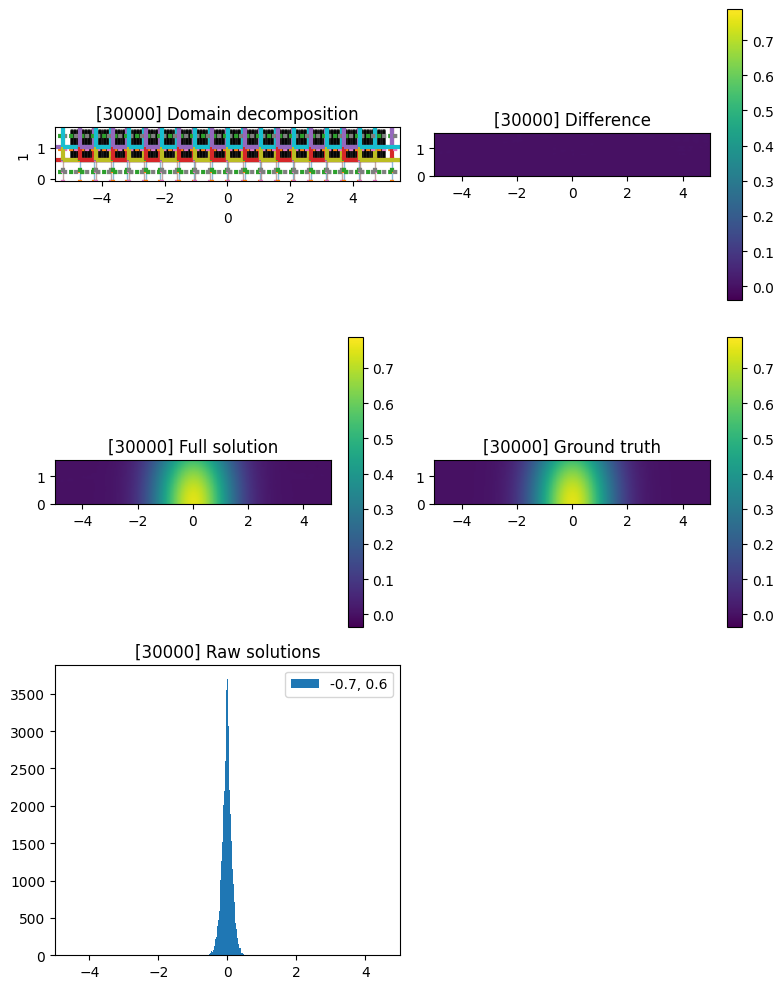

(2, 2) 2
True


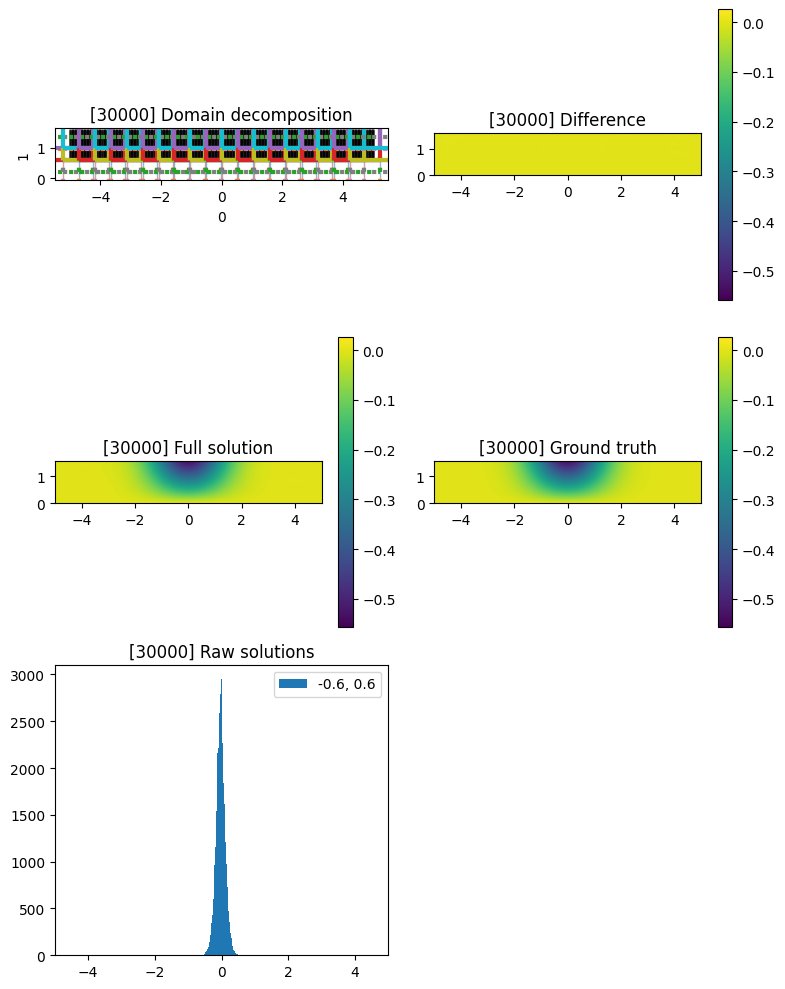

[INFO] 2025-03-28 01:21:14 - [i: 31000/50000] loss: 0.0063 rate: 569.2 elapsed: 0.02 hr test
[INFO] 2025-03-28 01:21:16 - [i: 32000/50000] loss: 0.0062 rate: 571.0 elapsed: 0.02 hr test
[INFO] 2025-03-28 01:21:18 - [i: 33000/50000] loss: 0.0050 rate: 569.8 elapsed: 0.02 hr test
[INFO] 2025-03-28 01:21:19 - [i: 34000/50000] loss: 0.0061 rate: 568.6 elapsed: 0.02 hr test
[INFO] 2025-03-28 01:21:21 - [i: 35000/50000] loss: 0.0052 rate: 560.4 elapsed: 0.02 hr test
(10000, 2) (10000, 2) (10000, 2) (76380, 2) (76380, 1) (76380, 2) (6200, 2) (200, 50)
(2, 2) 2
True


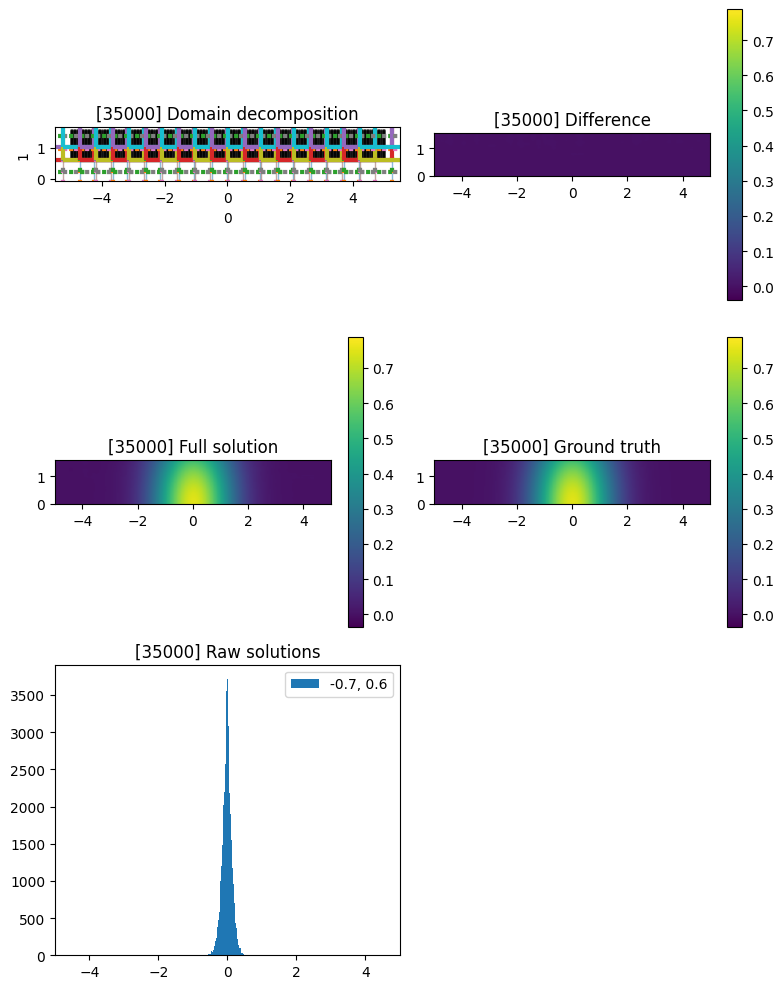

(2, 2) 2
True


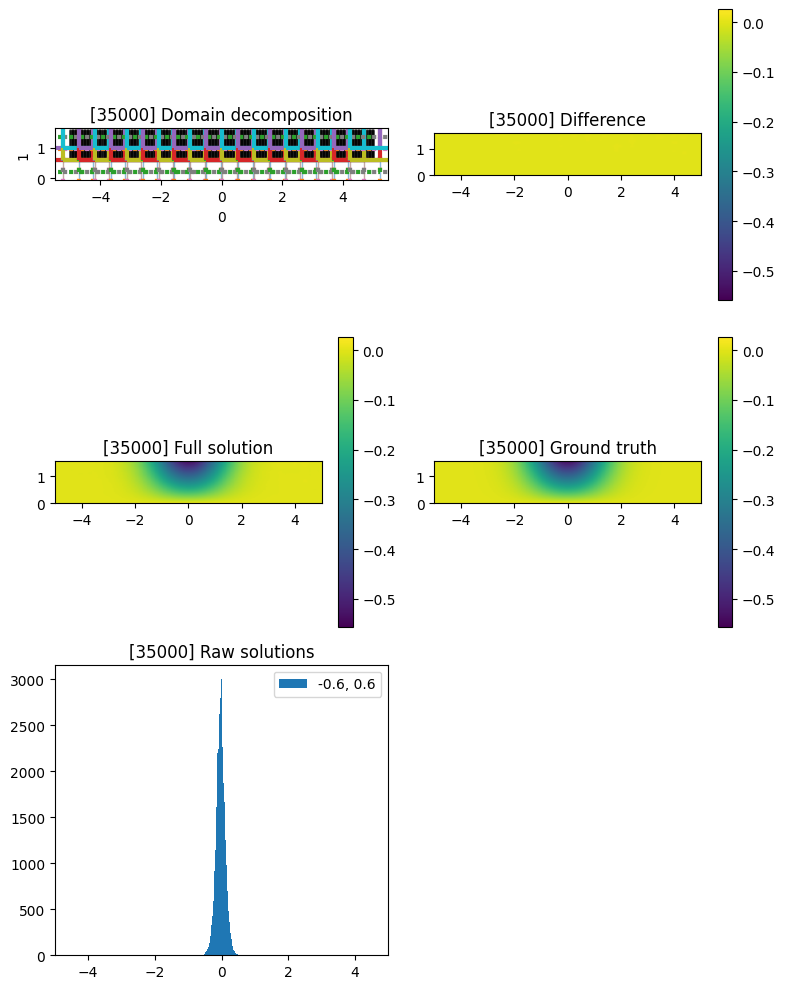

[INFO] 2025-03-28 01:21:24 - [i: 36000/50000] loss: 0.0069 rate: 556.4 elapsed: 0.02 hr test
[INFO] 2025-03-28 01:21:26 - [i: 37000/50000] loss: 0.0045 rate: 537.7 elapsed: 0.02 hr test
[INFO] 2025-03-28 01:21:28 - [i: 38000/50000] loss: 0.0049 rate: 555.2 elapsed: 0.02 hr test
[INFO] 2025-03-28 01:21:29 - [i: 38889/50000] Updating active inputs..
[INFO] 2025-03-28 01:21:29 - [i: 38889/50000] Average number of points/dimension in active subdomains: 22.65
[INFO] 2025-03-28 01:21:29 - [i: 38889/50000] Updating active inputs done (0.08 s)
[INFO] 2025-03-28 01:21:29 - [i: 38889/50000] Compiling update step..
[INFO] 2025-03-28 01:21:29 - x_batch
[INFO] 2025-03-28 01:21:29 - (3600, 2), float32, JVPTracer
[INFO] 2025-03-28 01:21:29 - x_take
[INFO] 2025-03-28 01:21:29 - (26790, 2), float32, JVPTracer
[INFO] 2025-03-28 01:21:30 - x_batch
[INFO] 2025-03-28 01:21:30 - (3600, 2), float32, JVPTracer
[INFO] 2025-03-28 01:21:30 - x_take
[INFO] 2025-03-28 01:21:30 - (26790, 2), float32, JVPTracer
[INF

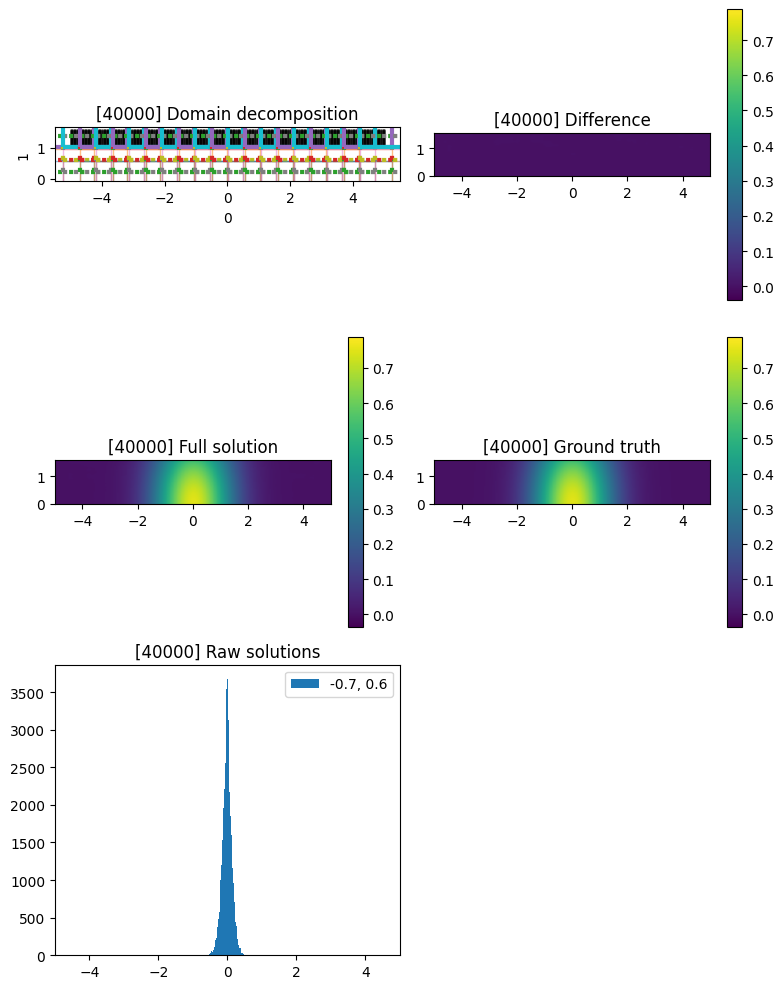

(2, 2) 2
True


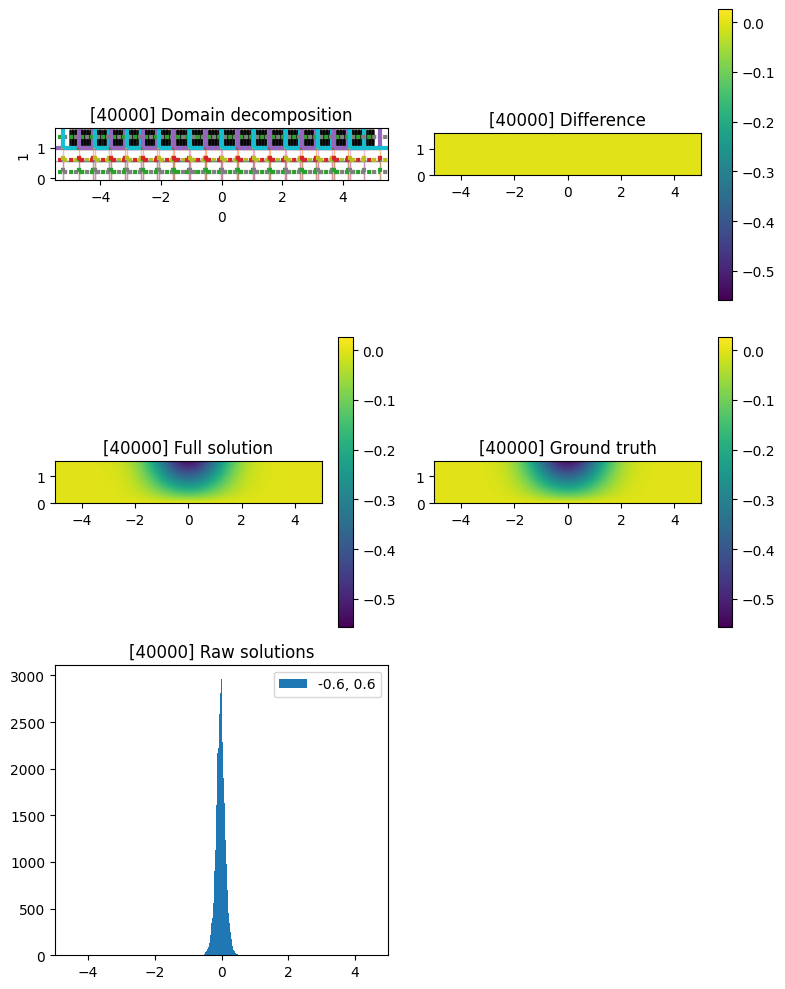

[INFO] 2025-03-28 01:21:34 - [i: 41000/50000] loss: 0.0060 rate: 1120.8 elapsed: 0.03 hr test
[INFO] 2025-03-28 01:21:35 - [i: 42000/50000] loss: 0.0064 rate: 1067.6 elapsed: 0.03 hr test
[INFO] 2025-03-28 01:21:36 - [i: 43000/50000] loss: 0.0058 rate: 1109.7 elapsed: 0.03 hr test
[INFO] 2025-03-28 01:21:37 - [i: 44000/50000] loss: 0.0049 rate: 1100.0 elapsed: 0.03 hr test
[INFO] 2025-03-28 01:21:38 - [i: 45000/50000] loss: 0.0048 rate: 1052.3 elapsed: 0.03 hr test
(10000, 2) (10000, 2) (10000, 2) (76380, 2) (76380, 1) (76380, 2) (3600, 2) (200, 50)
(2, 2) 2
True


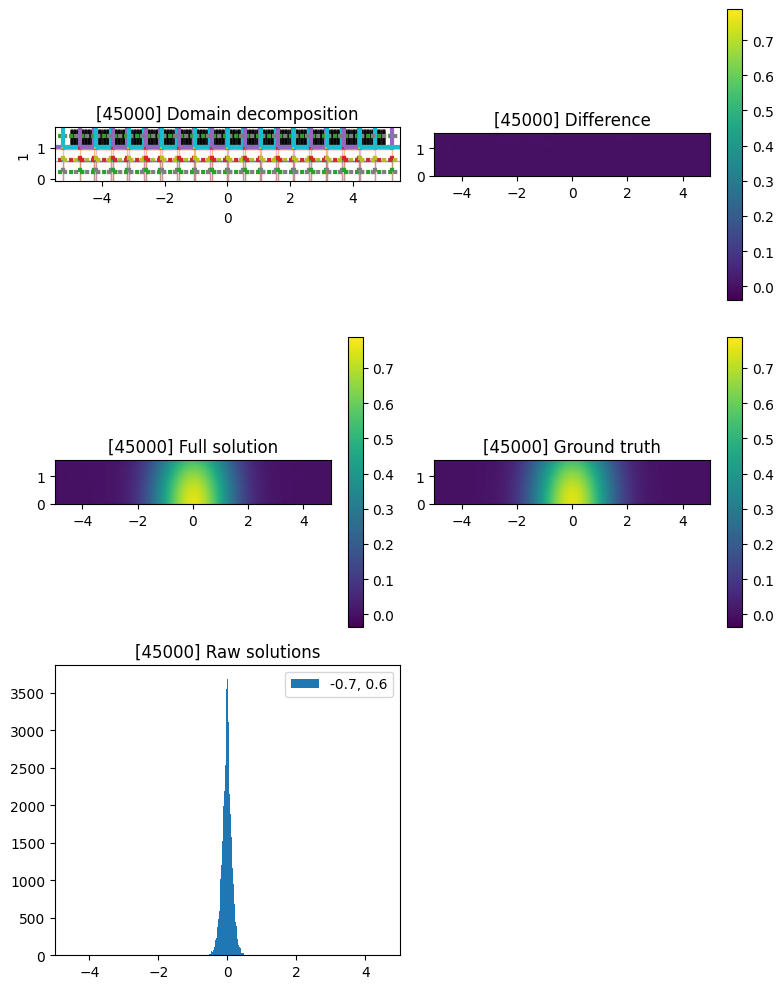

(2, 2) 2
True


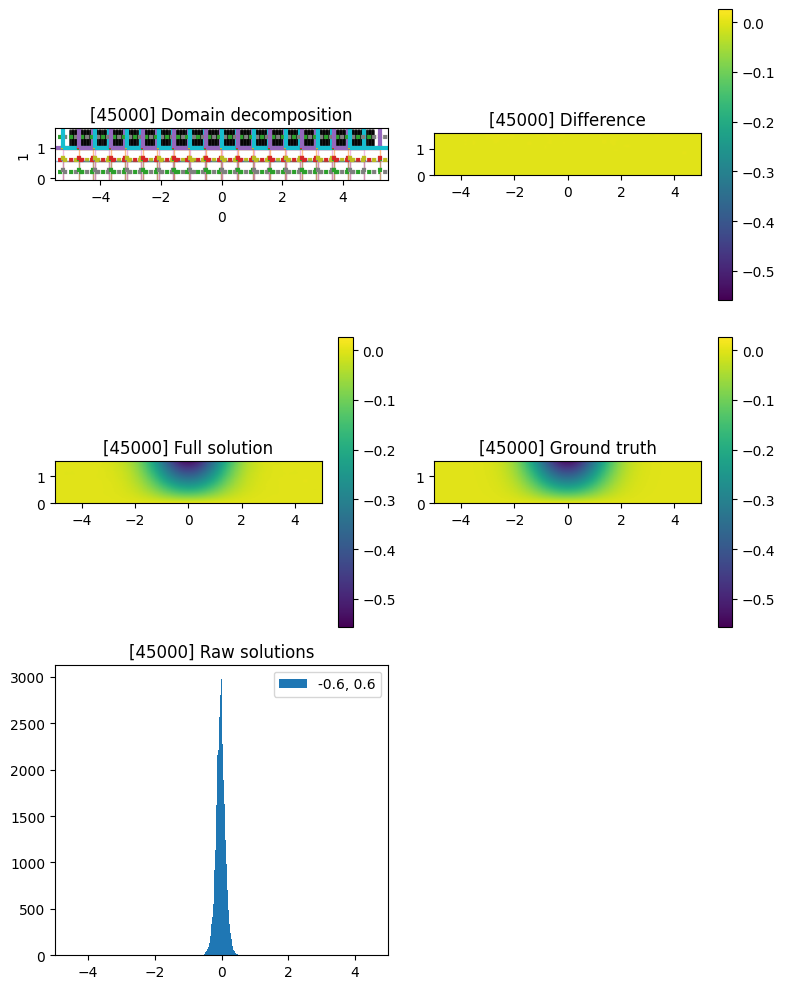

[INFO] 2025-03-28 01:21:40 - [i: 46000/50000] loss: 0.0050 rate: 1087.3 elapsed: 0.03 hr test
[INFO] 2025-03-28 01:21:41 - [i: 47000/50000] loss: 0.0060 rate: 1083.2 elapsed: 0.03 hr test
[INFO] 2025-03-28 01:21:42 - [i: 48000/50000] loss: 0.0053 rate: 1057.7 elapsed: 0.03 hr test
[INFO] 2025-03-28 01:21:43 - [i: 49000/50000] loss: 0.0055 rate: 1084.9 elapsed: 0.03 hr test
[INFO] 2025-03-28 01:21:44 - [i: 50000/50000] loss: 0.0056 rate: 1103.7 elapsed: 0.03 hr test
(10000, 2) (10000, 2) (10000, 2) (76380, 2) (76380, 1) (76380, 2) (3600, 2) (200, 50)
(2, 2) 2
True


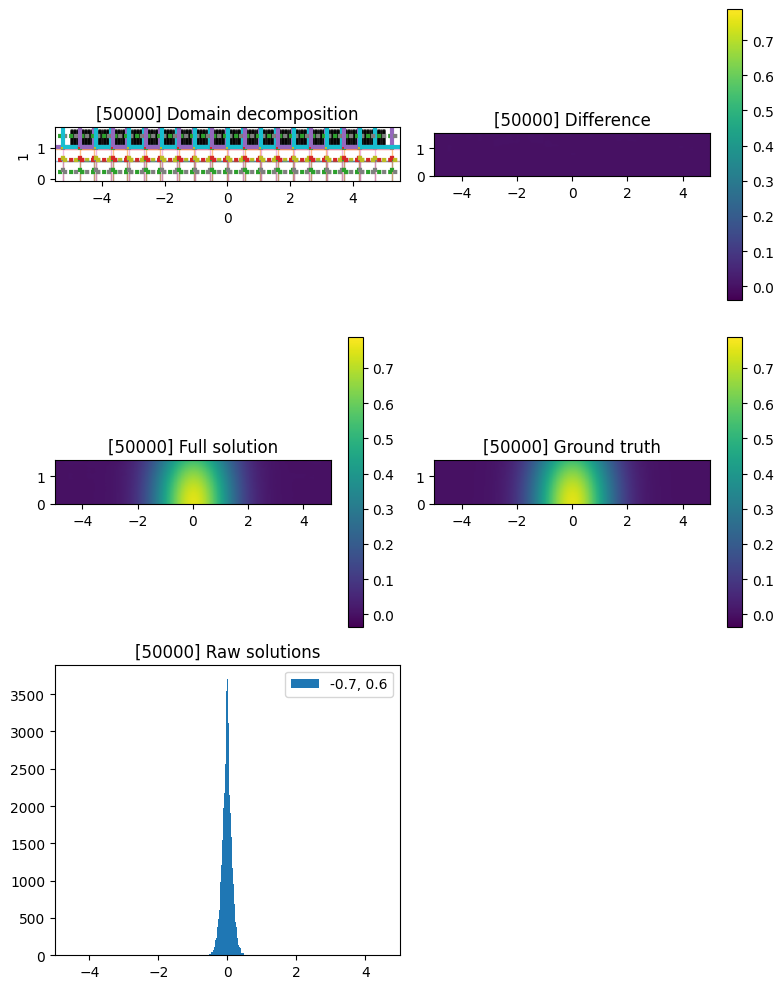

(2, 2) 2
True


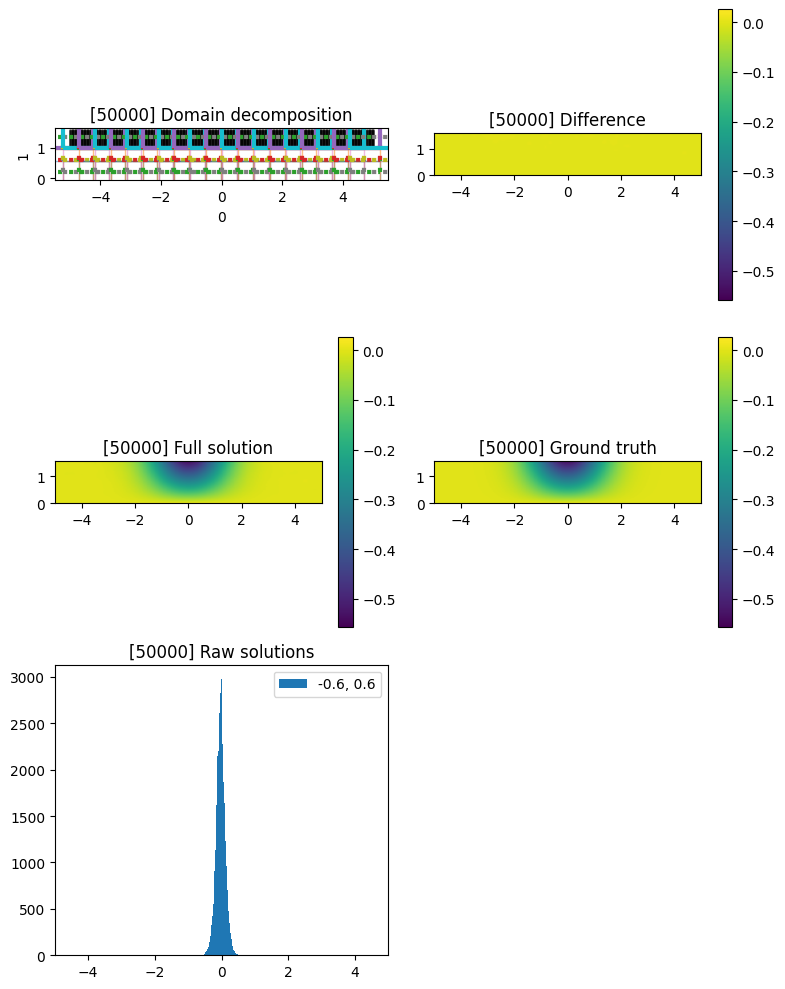

[INFO] 2025-03-28 01:21:44 - [i: 50000/50000] Training complete


In [3]:
import numpy as np

from fbpinns.domains import RectangularDomainND
from fbpinns.decompositions import RectangularDecompositionND
from fbpinns.networks import FCN, ChebyshevKAN
from fbpinns.schedulers import LineSchedulerRectangularND
from fbpinns.constants import Constants, get_subdomain_ws
from fbpinns.trainers import FBPINNTrainer

x_min, x_max = -5., 5.
t_min, t_max = 0., jnp.pi * 0.5
subdomain_xs=[np.linspace(x_min, x_max, 20), np.linspace(t_min, t_max, 5)]
c = Constants(
    domain=RectangularDomainND,
    domain_init_kwargs = dict(
        xmin=np.array([x_min,t_min]),
        xmax=np.array([x_max,t_max])
        ),
    problem=Schrodinger1D,
    problem_init_kwargs = dict(
    ),
    decomposition=RectangularDecompositionND,
    decomposition_init_kwargs=dict(
        subdomain_xs=subdomain_xs,
        subdomain_ws=get_subdomain_ws(subdomain_xs, 2.9),
        unnorm=(0.,3.),
    ),
    # network=FCN,
    # network_init_kwargs = dict(
    #     layer_sizes = (2, 16, 1),
    # ),
    network=ChebyshevKAN,# place a fully-connected network in each subdomain
    network_init_kwargs=dict(
        input_dim=2,
        output_dim=2,
        degree=15
    ),
    scheduler = LineSchedulerRectangularND,
    scheduler_kwargs = dict(
        point=[0.], iaxis=0,
    ),
    optimiser_kwargs = dict(
        learning_rate=0.001
        ),
    ns=((200,50),),
    n_test=(200,50),
    n_steps=50000,
    clear_output=False,
)

run = FBPINNTrainer(c)
all_params = run.train()